# ATLAS *Z*+jets MultiFold: Pseudo measurement

This notebook presents an unbinned and high-dimensional measurement of $Z$+jets differential cross sections based on 
the OmniFold method [arXiv:1911.09107](https://arxiv.org/abs/1911.09107). The measurment is fully corrected for detector effects, i.e. unfolded to the particle (truth) level. 

**The "data" used in this notebook is not real data, but pseudo-data**, generated from MC simulation that was reweighted to match the actual data (Run 2 ATLAS $pp$ dataset at $\sqrt{s}=13$ TeV).
This means that we have a known *target* for this dataset, defined by the underlying particle-level distributions. The pseudo-data was generated using the alternative Drell-Yan sample, generated by Sherpa 2.2.11. 

*This is hence not a real measurement of nature, but a realistic pseudo-measurement with a known answer.* 
We recommend any analysis of the [real measurement](./3_results.ipynb) to first validate their procedure using this notebook.

While a [dedicated notebook provides technical setup instructions and demonstrates basic usage](./1_basics.ipynb), this notebook gives examples of more advanced usage, such as how to obtain and plot binned differential cross sections, and accessing the associated covariance matrices. 

## 1. Initialization and loading of the data

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os
import pickle
from multifold_util import *

In [2]:
folder = "./files/"

print("Loading the measurement - based on pseudo-data with known underlying distribution (target).")
folder = os.path.join(folder, "pseudodata")
plot_dir = os.path.join(os.getcwd(), "plots", "pseudodata")
os.makedirs(plot_dir, exist_ok=True)

# This is the high statistics underlying particle level distribution
# The known target in this case. It was generating based on Sherpa 2.2.11 as the Drell-Yan component
target = pd.read_hdf(os.path.join(folder,"target.h5"))

# (Pseudo) measurement of the pseudo-data using the nominal MG5 sample
multifold = pd.read_hdf(os.path.join(folder,"multifold.h5"))
# (Pseudo) measurement of the pseudo-data using the alternative Sherpa sample for unfolding
multifold_sherpa = pd.read_hdf(os.path.join(folder,"multifold_sherpa.h5"))
multifold_nonDY  = pd.read_hdf(os.path.join(folder,"multifold_nonDY.h5")) 
mc_preds = np.load(os.path.join(folder,"mc_preds.npy"), allow_pickle=True)

Loading the measurement - based on pseudo-data with known underlying distribution (target).


In [3]:
### Construct masks for track pT cuts
mask_trackj1 = np.array(multifold['pT_trackj1'] > 5, dtype='bool')
mask_trackj2 = np.array(multifold['pT_trackj2'] > 5, dtype='bool')

mask_sherpa_trackj1 = np.array(multifold_sherpa['pT_trackj1'] > 5, dtype='bool')
mask_sherpa_trackj2 = np.array(multifold_sherpa['pT_trackj2'] > 5, dtype='bool')

mask_nonDY_trackj1 = np.array(multifold_nonDY['pT_trackj1'] > 5, dtype='bool')
mask_nonDY_trackj2 = np.array(multifold_nonDY['pT_trackj2'] > 5, dtype='bool')

mask_target_trackj1 = np.array(target['pT_trackj1'] > 5, dtype='bool')
mask_target_trackj2 = np.array(target['pT_trackj2'] > 5, dtype='bool')

## 2. Choice of variables and binning

An inherent advantage to MultiFold is that it performs an *unbinned* unfolding, meaning we can adjust the bins as we please. However, as stated in the supplementary material of the paper, the chosen binning should fulfill two conditions: sufficient statistical precision specified by $N_\text{eff} > 5000$; and, sufficient support by actual data by requiring a data statistical uncertainty smaller than 15%. These criteria are implemented in the [equal_effective_statistics method in the utility file](./multifold_util.py).

As part of the analysis, we compared the unbinned results with results obtained using the traditional unfolding technique: Iterative Bayesian Unfolding (IBU). We settled on a binning adequate for IBU, which is loaded in the box below. This binning is used for the results produced in this notebook and is also what is used for the results shown in the paper.

In [4]:
bins_dict = ibu_bins # defined in demo_functions.py
# bins_dict['Ntracks_trackj1'] = [0.5, 2] # example of how to modify binning for a given variable

print(f"Loaded bins for {len(bins_dict)} observables:")
for obs, bins in bins_dict.items():
    print("{:>15} with {:2} bins [{:.1f} ... {:.1f}]".format(obs,len(bins),bins[0],bins[-1]))
    # print("  {}, {} bins: {}".format(obs,len(bins),bins))

Loaded bins for 24 observables:
          pT_l1 with  7 bins [25.0 ... 800.0]
          pT_l2 with  7 bins [25.0 ... 400.0]
         eta_l1 with 15 bins [-2.5 ... 2.5]
         eta_l2 with 15 bins [-2.5 ... 2.5]
         phi_l1 with 17 bins [-3.1 ... 3.1]
         phi_l2 with 17 bins [-3.1 ... 3.1]
     pT_trackj1 with  7 bins [5.0 ... 1000.0]
     pT_trackj2 with  5 bins [5.0 ... 500.0]
      y_trackj1 with 19 bins [-2.5 ... 2.5]
      y_trackj2 with 11 bins [-2.5 ... 2.5]
    phi_trackj1 with 17 bins [-3.1 ... 3.1]
    phi_trackj2 with 17 bins [-3.1 ... 3.1]
          pT_ll with  6 bins [200.0 ... 1000.0]
           y_ll with 15 bins [-2.5 ... 2.5]
Ntracks_trackj1 with  7 bins [0.5 ... 39.5]
Ntracks_trackj2 with  6 bins [0.5 ... 34.5]
      m_trackj1 with  7 bins [0.0 ... 70.0]
      m_trackj2 with  5 bins [0.0 ... 40.0]
   tau1_trackj1 with  8 bins [0.0 ... 0.9]
   tau1_trackj2 with  6 bins [0.0 ... 0.9]
   tau2_trackj1 with  8 bins [0.0 ... 0.5]
   tau2_trackj2 with  6 bins [0.0 ..

# Results of the 24 directly measured observables

## 3. Calculation of uncertainties

The next two code blocks first creates groups of uncertainites for dedicated uncertainty plots.

Next, uncertainties are loaded or calculated such that they can be accessed for the result plots.
Uncertainties for all 24 unfolded observables are calculated using the binning defined above.

In [5]:
# List of systematic uncertainties, stored as weights in the dataset
event_systs     = [col for col in multifold.keys() if col.startswith("weights_muEff")] + ['weights_pileup']
theory_systs    = [col for col in multifold.keys() if col.startswith("weights_theory")]
track_systs     = [col for col in multifold.keys() if col.startswith("weights_track")]
muon_systs      = [col for col in multifold.keys() if col.startswith("weights_muCal")]

# List of stochastic uncertaintty names
mc_stat_systs   = [col for col in multifold.keys() if col.startswith("weights_bootstrap_mc")]
data_stat_systs = [col for col in multifold.keys() if col.startswith("weights_bootstrap_data")]
ensemble_systs  = [col for col in multifold.keys() if col.startswith("weights_ensemble")]

In [6]:
if os.path.exists(os.getcwd()+'/pseudodata_uncertainties.p'):
    print("Using pre-calculated uncertainties.") 
    uncertainties = np.load(os.getcwd()+'/pseudodata_uncertainties.p', allow_pickle=True)
else:
    print("Recalculating uncertainties from scratch.")
    uncertainties = {}

    for i in tqdm(range(24), desc="Unfolded vars"): # number of unfolded observables
        var = list(bins_dict.items())[i][0]
        bins = np.array(list(bins_dict.items())[i][1])
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        if "trackj1" in var: 
            df = multifold[mask_trackj1]
            df_sherpa = multifold_sherpa[mask_sherpa_trackj1]
            df_nonDY = multifold_nonDY[mask_nonDY_trackj1]
        elif "trackj2" in var:
            df = multifold[mask_trackj2]
            df_sherpa = multifold_sherpa[mask_sherpa_trackj2]
            df_nonDY = multifold_nonDY[mask_nonDY_trackj2]
        else:
            df = multifold
            df_sherpa = multifold_sherpa
            df_nonDY = multifold_nonDY
            
        nom, _ = np.histogram(df[var], bins=bins, weights=df.weights_nominal)    

        final_event          = calculate_uncertainty(df, var, bins, event_systs)
        final_theory         = calculate_uncertainty(df, var, bins, theory_systs)
        final_track          = calculate_uncertainty(df, var, bins, track_systs)
        final_muon           = calculate_uncertainty(df, var, bins, muon_systs)
        final_mc_stat        = calculate_stat_uncertainty(df, var, bins, mc_stat_systs)
        final_data_stat      = calculate_stat_uncertainty(df, var, bins, data_stat_systs)
        final_nn_init        = calculate_stat_uncertainty(df, var, bins, ensemble_systs)/np.sqrt(len(ensemble_systs))
        
        ### Unfolding (DD)
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_dd)
        target_dd, _ = np.histogram(df[var], bins=bins, weights=df.target_dd)
        final_unfolding_dd = 100*np.sqrt((syst-target_dd)**2)/target_dd

        ### Unfolding (HV)
        syst, _ = np.histogram(df_sherpa[var], bins=bins, weights=df_sherpa.weights_nominal)
        smoothed_hv_syst_signed = smooth_uncertainty(syst-nom, bin_centers)
        final_unfolding_hv = 100*np.sqrt((smoothed_hv_syst_signed)**2)/nom

        ### Sum these together in quadrature
        final_unfolding = np.sqrt(final_unfolding_hv**2 + final_unfolding_dd**2)

        ### Luminosity 
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_lumi)
        final_lumi = 100*np.sqrt((syst-nom)**2)/nom

        ### Top Background 
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_topBackground)
        final_top = 100*np.sqrt((syst-nom)**2)/nom

        ### Non-Strong Background
        syst, _ = np.histogram(df_nonDY[var], bins=bins, weights=df_nonDY.weights_nominal)
        final_nonDY = 100*np.sqrt((syst-nom)**2)/nom

        final_exp = np.sqrt(final_lumi**2 + final_muon**2 + final_track**2 + final_event**2)
        uncertainties[var+"_exp"] = final_exp
        uncertainties[var+"_theory"] = final_theory
        uncertainties[var+"_mc_stat"] = np.sqrt(final_mc_stat**2 + final_nn_init**2)
        uncertainties[var+"_data_stat"] = final_data_stat
        uncertainties[var+"_unfolding"] = final_unfolding
        uncertainties[var+"_top"] = final_top
        uncertainties[var+"_nonDY"] = final_nonDY

        total = np.sqrt(
            + final_theory**2 
            + final_exp**2
            + final_mc_stat**2
            + final_data_stat**2
            + final_unfolding**2
            + final_top**2
            + final_nonDY**2
        )
        uncertainties[var+"_total"] = total

Using pre-calculated uncertainties.


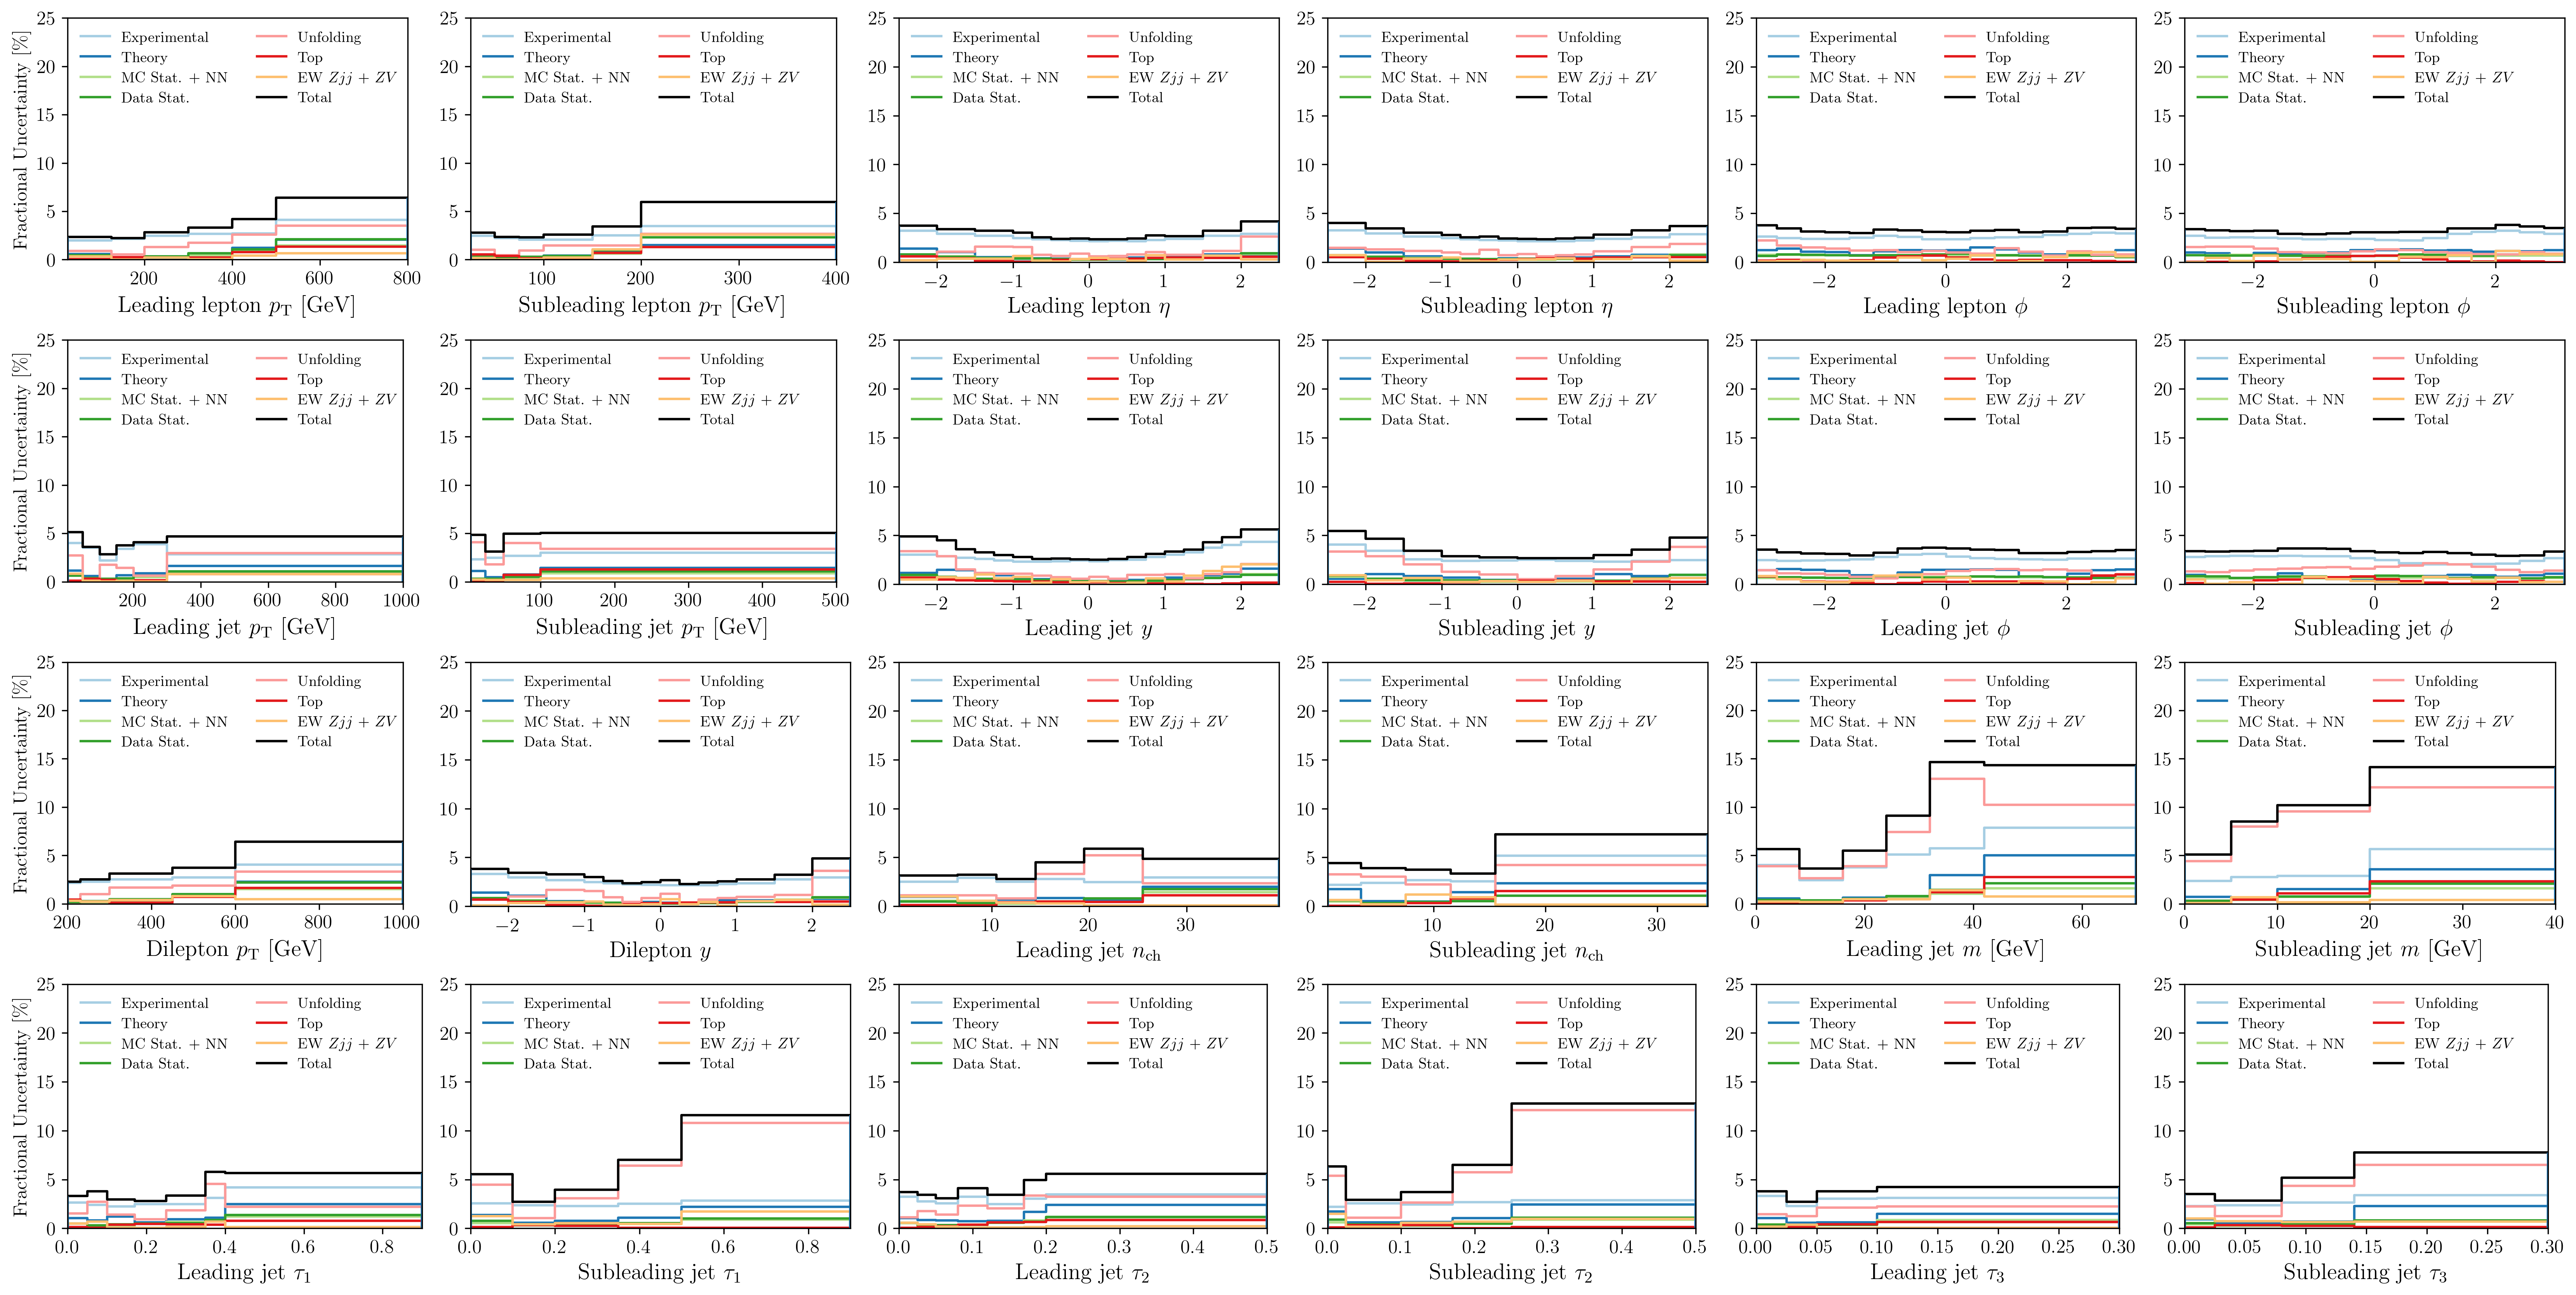

In [7]:
fig = plt.figure(figsize=(22,11), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(4, 6)

for i, subfig in enumerate(subfigs.flat):
    ax = subfig.subplots(1, 1)
    colors = [plt.cm.Paired(i) for i in range(20)]
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])

    ax.step(bins, np.concatenate([[uncertainties[var+'_exp'][0]],uncertainties[var+'_exp']]),              label = "Experimental",       color=colors[0],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_theory'][0]],uncertainties[var+'_theory']]),        label = "Theory",             color=colors[1],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_mc_stat'][0]],uncertainties[var+'_mc_stat']]),      label = "MC Stat. + NN",      color=colors[2],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_data_stat'][0]],uncertainties[var+'_data_stat']]),  label = "Data Stat.",         color=colors[3],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_unfolding'][0]],uncertainties[var+'_unfolding']]),  label = "Unfolding",          color=colors[4]     )
    ax.step(bins, np.concatenate([[uncertainties[var+'_top'][0]],uncertainties[var+'_top']]),              label = "Top",                color=colors[5],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_nonDY'][0]],uncertainties[var+'_nonDY']]),          label = r"EW $Zjj$ + $ZV$",   color=colors[6],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_total'][0]],uncertainties[var+'_total']]),          label = "Total",              color='black',      )

    ### draw lines at the beginning and end of the first and last bins, for plotting purposes
    label_list = ['exp', 'theory', 'mc_stat', 'data_stat', 'unfolding', 'top', 'nonDY', 'total']
    for label in label_list:
        plt.vlines(x=bins[0], ymin=0, ymax=uncertainties[var+'_'+label][0])
        plt.vlines(x=bins[-1], ymin=0, ymax=uncertainties[var+'_'+label][-1])

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    if i % 6 == 0: ax.set_ylabel(r"Fractional Uncertainty [\%]", fontsize=12)
    ax.legend(fontsize=9, loc='upper left', ncol=2, frameon=False)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0, 25])
    ax.set_xlabel(plot_labels[var], fontsize=14);
    
plt.savefig(os.path.join(plot_dir,"total_systs.pdf"))

### Plot results

Plots: 100%|██████████| 24/24 [00:55<00:00,  2.31s/it]


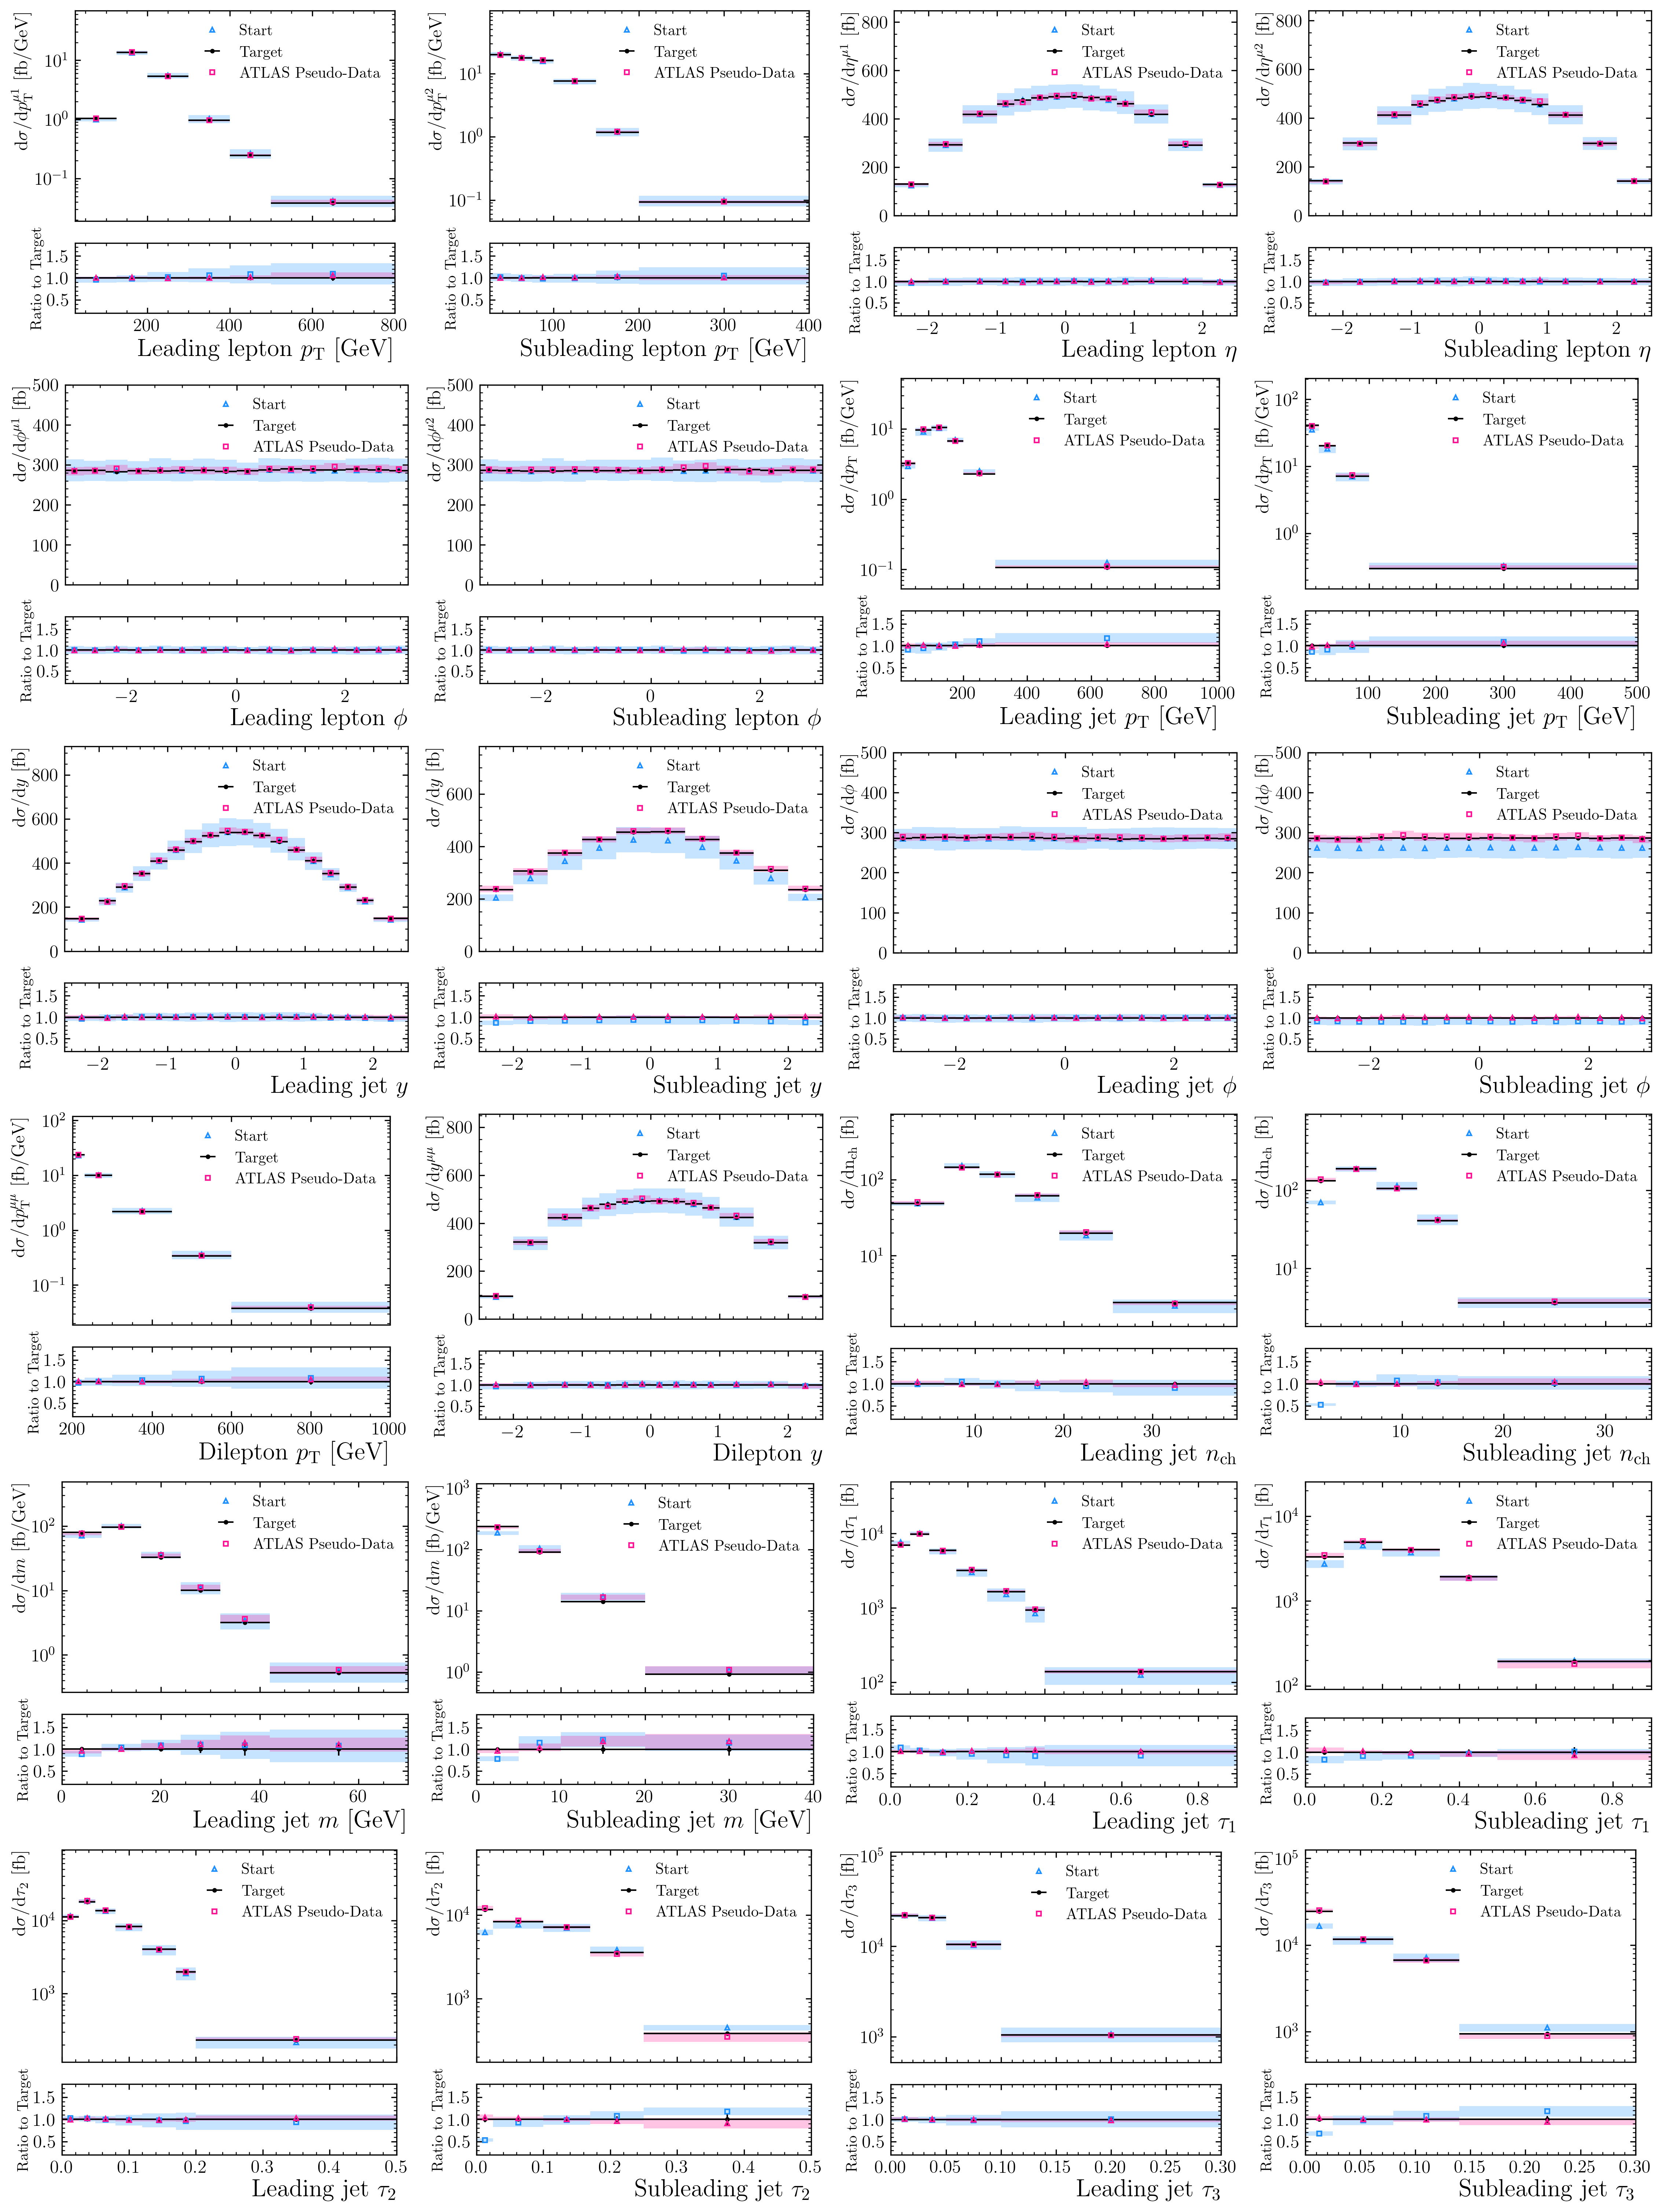

In [8]:
fig = plt.figure(figsize=(15,20), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(6, 4)

for i, subfig in enumerate(tqdm(subfigs.flat, desc="Plots")):  
    axs = subfig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]})
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = np.array([bins[n+1] - bins[n] for n in range(len(bins)-1)])
    
    if "trackj1" in var: 
        df = multifold[mask_trackj1]
    elif "trackj2" in var:
        df = multifold[mask_trackj2]
    else:
        df = multifold    
    
    ### Starting distribution
    counts = mc_preds[i]['mgfxfx_counts']
    start_density = counts/lumi/bin_widths
    start_error = mc_preds[i]['mgfxfx_err']/mc_preds[i]['mgfxfx_counts']
    _ = make_error_boxes(axs[0], bin_centers, start_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([start_density*start_error, start_density*start_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label='Start')
    
    ### Target distribution (note: this is the pseudodata truth)
    target_density, _, _ = axs[0].hist(target[var], bins=bins, density=True, weights=target.weight_mc, color='k', alpha=0)
    target_density *= np.sum(target.weight_mc)
    axs[0].errorbar(bin_centers, target_density, xerr=bin_widths/2, yerr=None, marker=".", linestyle="None", color="k", alpha=1, ecolor='k', label="Target", markersize=4, linewidth=1)

    ### MultiFold
    multifold_density, _, _ = axs[0].hist(multifold[var], weights=multifold.weights_nominal, bins=bins, histtype= 'step', color= 'black', linewidth= 2, density=True, alpha=0)
    multifold_density *= np.sum(multifold.weights_nominal)
    _ = make_error_boxes(axs[0], bin_centers, multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([multifold_density*uncertainties[var+"_total"]/100, multifold_density*uncertainties[var+"_total"]/100]), facecolor='deeppink', alpha=0.25, marker="s", label='ATLAS Pseudo-Data')

    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[0].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
    axs[0].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
    axs[0].set_ylabel(labels[var], fontsize=12, labelpad=2, loc='top')
    axs[0].set_ylim([0, 1.7 * max(max(target_density), max(multifold_density))])
    
    ### Set most plots to use log scale
    if 'phi' not in var and 'eta' not in var and 'y' not in var:
        axs[0].set_yscale('log')
        axs[0].set_ylim([0.5*min(min(target_density), min(multifold_density)), 5 * max(max(target_density), max(multifold_density))])
    
    elif 'phi' in var:
        axs[0].set_ylim(0,500)
    
    axs[0].legend(fontsize=10, frameon=False, loc='best', ); 

    axs[1].errorbar(bin_centers, np.ones(len(bin_centers)), xerr=bin_widths/2, yerr=uncertainties[var+"_total"]/100, marker=".", linestyle="None", color="k", alpha=1,  ecolor='k', label="ATLAS Pseudo-Data", markersize=4, linewidth=1)
    _ = make_error_boxes(axs[1], bin_centers, start_density/target_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(start_density/target_density)*start_error, (start_density/target_density)*start_error]), facecolor='dodgerblue', alpha=0.25, marker="s", label=r'Start')
    _ = make_error_boxes(axs[1], bin_centers, multifold_density/target_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(multifold_density/target_density)*uncertainties[var+"_total"]/100, (multifold_density/target_density)*uncertainties[var+"_total"]/100]), facecolor='deeppink', alpha=0.25, marker="^", label=r'MG5+Py8 + $\mathbf{X}$')
    axs[1].set_xlim(bins[0], bins[-1])
    axs[1].set_ylim([0.2,1.8])
    axs[1].xaxis.set_tick_params(labelsize=12, which='both', direction='in', top=True)
    axs[1].yaxis.set_tick_params(labelsize=12, which='both', direction='in', right=True)
    axs[1].set_ylabel('Ratio to Target', fontsize=10, labelpad=2, loc='center')
    axs[1].set_xlabel(plot_labels[var], fontsize=16, labelpad=2, loc='right');
    
plt.savefig(os.path.join(plot_dir,"nominal_diff_xsec.pdf"))

# Derived variable results

Now we'll calculate two additional variables that weren't present in the 24-dimensional unfolding, but are combinations of the unfolded variables: 

1. $\tau_{21} \equiv \tau_2/\tau_1$
2. $\Delta R(j_1, ll)$

In [9]:
### Define new variables
def calculate_vars(df): 
    ### tau21 = tau2/tau1 
    df['tau21'] = df.tau2_trackj1/df.tau1_trackj1
    
    ### deltaR(ll, j1) 
    def dR(v1, v2):
        dy = v1.rapidity-v2.rapidity
        dphi = v1.deltaphi(v2)
        return np.sqrt(dy**2 + dphi**2)

    def dR_ll_trackj1(pT_l1, eta_l1, phi_l1, 
                      pT_l2, eta_l2, phi_l2, 
                      pT_trackj1, y_trackj1, phi_trackj1):
        l1 = vector.array({
            "pt": pT_l1,
            "phi": phi_l1,
            "eta": eta_l1,
            "m":np.zeros_like(pT_l1)
        })
        l2 = vector.array({
            "pt": pT_l2,
            "phi": phi_l2,
            "eta": eta_l2,
            "m":np.zeros_like(pT_l2)
        })
        track_j1 = vector.array({
            "pt": pT_trackj1,
            "phi": phi_trackj1,
            "eta": y_trackj1,
            "m":np.zeros_like(pT_trackj1)
        })

        ll = l1 + l2
        return dR(ll, track_j1)
    
    def phi_ll(pt_l1, eta_l1, phi_l1, pt_l2, eta_l2, phi_l2): 
            l1 = vector.array({"pt": pt_l1, "eta": eta_l1, "phi": phi_l1, "m": np.zeros(len(pt_l1))})
            l2 = vector.array({"pt": pt_l2, "eta": eta_l2, "phi": phi_l2, "m": np.zeros(len(pt_l2))})
            return l1.add(l2).phi
    
    df['phi_ll'] = phi_ll(np.array(df.pT_l1), np.array(df.eta_l1), np.array(df.phi_l1), 
                          np.array(df.pT_l2), np.array(df.eta_l2), np.array(df.phi_l2))
    df['dR_ll'] = dR_ll_trackj1(
        np.array(df.pT_l1), np.array(df.eta_l1), np.array(df.phi_l1), 
        np.array(df.pT_l2), np.array(df.eta_l2), np.array(df.phi_l2),
        np.array(df.pT_trackj1), np.array(df.y_trackj1), np.array(df.phi_trackj1))
    
    return df

### Pick bins for each of these new variables
bins_dict['tau21'] = [0.0, 0.35, 0.51, 0.63, 0.71, 0.78, 1.0]
bins_dict['dR_ll'] = [0.0, 2.0, 2.4, 2.6, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.6, 4.0, 6.0]

### Define plot labels
plot_labels['tau21'] = r'Leading jet $\tau_2/\tau_1$'
plot_labels['dR_ll'] = r'$\Delta R(\ell\ell,j_1)$'
labels['tau21'] = r'd$\sigma$/d$\tau_{21}$ [fb]'
labels['dR_ll'] = r'd$\sigma$/d$\Delta R$ [fb]'

### Add these new variables to each dataset
for dataframe in tqdm([multifold, multifold_sherpa, multifold_nonDY, target], desc="Calculating..."): 
    dataframe = calculate_vars(dataframe)

Calculating...: 100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


### *Optional*: Creating an automatic binning with a given number of effective events

In [10]:
N = 10_000  # Number of effective events per bin
var = 'tau21'
bin_edges = equal_effective_events_bins(multifold, var, N)
print(bin_edges)

Dividing into 21 bins of 10000 effective events.


100%|██████████| 418014/418014 [00:10<00:00, 38990.14it/s]

[0.0, 0.2904951870441437, 0.36279499530792236, 0.4135139584541321, 0.45304006338119507, 0.4855400621891022, 0.5140062570571899, 0.538831889629364, 0.5616281032562256, 0.5818194150924683, 0.6003902554512024, 0.6182918548583984, 0.635394811630249, 0.6514304876327515, 0.6670510768890381, 0.682347297668457, 0.6981683969497681, 0.7141839265823364, 0.7314924597740173, 0.7510181069374084, 0.7755770087242126, 0.9162741]


### Calculate uncertainties

In [11]:
if os.path.exists(os.getcwd()+'/pseudodata_uncertainties.p'):
    print("Using pre-calculated uncertainties.") 
else:
    print("Calculating uncertainties.")
    
    n_derived_vars = len(labels) - 24

    for i in tqdm(range(24,24+n_derived_vars), desc="Unfolded vars"): # number of unfolded vars
        var = list(bins_dict.items())[i][0]
        bins = np.array(list(bins_dict.items())[i][1])
        
        if var == "tau21" or var == "dR_ll":
            df = multifold[mask_trackj1]
            df_sherpa = multifold_sherpa[mask_sherpa_trackj1]
            df_nonDY = multifold_nonDY[mask_nonDY_trackj1]
        else:
            df = multifold
            df_sherpa = multifold_sherpa
            df_nonDY = multifold_nonDY
    
        nom, _ = np.histogram(df[var], bins=bins, weights=df.weights_nominal)    
        final_event          = calculate_uncertainty(df, var, bins, event_systs)
        final_theory         = calculate_uncertainty(df, var, bins, theory_systs)
        final_track          = calculate_uncertainty(df, var, bins, track_systs)
        final_muon           = calculate_uncertainty(df, var, bins, muon_systs)
        final_mc_stat        = calculate_stat_uncertainty(df, var, bins, mc_stat_systs)
        final_data_stat      = calculate_stat_uncertainty(df, var, bins, data_stat_systs)
        final_nn_init        = calculate_stat_uncertainty(df, var, bins, ensemble_systs)/np.sqrt(len(ensemble_systs))

        ### Unfolding (DD)
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_dd)
        target_dd, _ = np.histogram(df[var], bins=bins, weights=df.target_dd)
        final_unfolding_dd = 100*np.sqrt((syst-target_dd)**2)/target_dd        
        
        ### Unfolding (HV)
        syst, _ = np.histogram(df_sherpa[var], bins=bins, weights=df_sherpa.weights_nominal)
        smoothed_hv_syst_signed = smooth_uncertainty(syst-nom, bin_centers)
        final_unfolding_hv = 100*np.sqrt((smoothed_hv_syst_signed)**2)/nom

        ### Sum these together in quadrature
        final_unfolding = np.sqrt(final_unfolding_hv**2 + final_unfolding_dd**2)

        ### Luminosity 
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_lumi)
        final_lumi = 100*np.sqrt((syst-nom)**2)/nom

        ### Top Background 
        syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_topBackground)
        final_top = 100*np.sqrt((syst-nom)**2)/nom

        ### Non-Strong Background
        syst, _ = np.histogram(df_nonDY[var], bins=bins, weights=df_nonDY.weights_nominal)
        final_nonDY = 100*np.sqrt((syst-nom)**2)/nom

        final_exp = np.sqrt(final_lumi**2 + final_muon**2 + final_track**2 + final_event**2)
        uncertainties[var+"_exp"] = final_exp
        uncertainties[var+"_theory"] = final_theory
        uncertainties[var+"_mc_stat"] = np.sqrt(final_mc_stat**2 + final_nn_init**2)
        uncertainties[var+"_data_stat"] = final_data_stat
        uncertainties[var+"_unfolding"] = final_unfolding
        uncertainties[var+"_top"] = final_top
        uncertainties[var+"_nonDY"] = final_nonDY

        total = np.sqrt(
            + final_theory**2 
            + final_exp**2
            + final_mc_stat**2
            + final_data_stat**2
            + final_unfolding**2
            + final_top**2
            + final_nonDY**2
        )
        uncertainties[var+"_total"] = total

    # Now that we've collected all of these, save them! 
    pickle.dump(uncertainties, open(os.getcwd()+'/pseudodata_uncertainties.p', 'wb'))

Using pre-calculated uncertainties.


In [12]:
n_derived_vars = len(labels) - 24 

fig = plt.figure(figsize=(4*n_derived_vars,3), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(1, n_derived_vars)

for i, subfig in enumerate(subfigs.flat):
    i = i+24 # skip to derived variables
    ax = subfig.subplots(1, 1)
    colors = [plt.cm.Paired(i) for i in range(20)]
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])

    ax.step(bins, np.concatenate([[uncertainties[var+'_exp'][0]],uncertainties[var+'_exp']]),              label = "Experimental",       color=colors[0],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_theory'][0]],uncertainties[var+'_theory']]),        label = "Theory",             color=colors[1],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_mc_stat'][0]],uncertainties[var+'_mc_stat']]),      label = "MC Stat. + NN",      color=colors[2],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_data_stat'][0]],uncertainties[var+'_data_stat']]),  label = "Data Stat.",         color=colors[3],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_unfolding'][0]],uncertainties[var+'_unfolding']]),  label = "Unfolding",          color=colors[4]     )
    ax.step(bins, np.concatenate([[uncertainties[var+'_top'][0]],uncertainties[var+'_top']]),              label = "Top",                color=colors[5],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_nonDY'][0]],uncertainties[var+'_nonDY']]),          label = r"EW $Zjj$ + $ZV$",   color=colors[6],    )
    ax.step(bins, np.concatenate([[uncertainties[var+'_total'][0]],uncertainties[var+'_total']]),          label = "Total",              color='black',      )

    ### draw lines at the beginning and end of the first and last bins, for plotting purposes
    label_list = ['exp', 'theory', 'mc_stat', 'data_stat', 'unfolding', 'top', 'nonDY', 'total']
    for label in label_list:
        plt.vlines(x=bins[0], ymin=0, ymax=uncertainties[var+'_'+label][0])
        plt.vlines(x=bins[-1], ymin=0, ymax=uncertainties[var+'_'+label][-1])

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_ylabel(r"Fractional Uncertainty [\%]", fontsize=10, loc='top')
    ax.legend(fontsize=8, loc='upper left', ncol=2, frameon=False)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0, 25])
    ax.set_xlabel(plot_labels[var], fontsize=14);
        
plt.savefig(os.path.join(plot_dir,"total_systs_derived.pdf"))

### Plot results

Plots: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


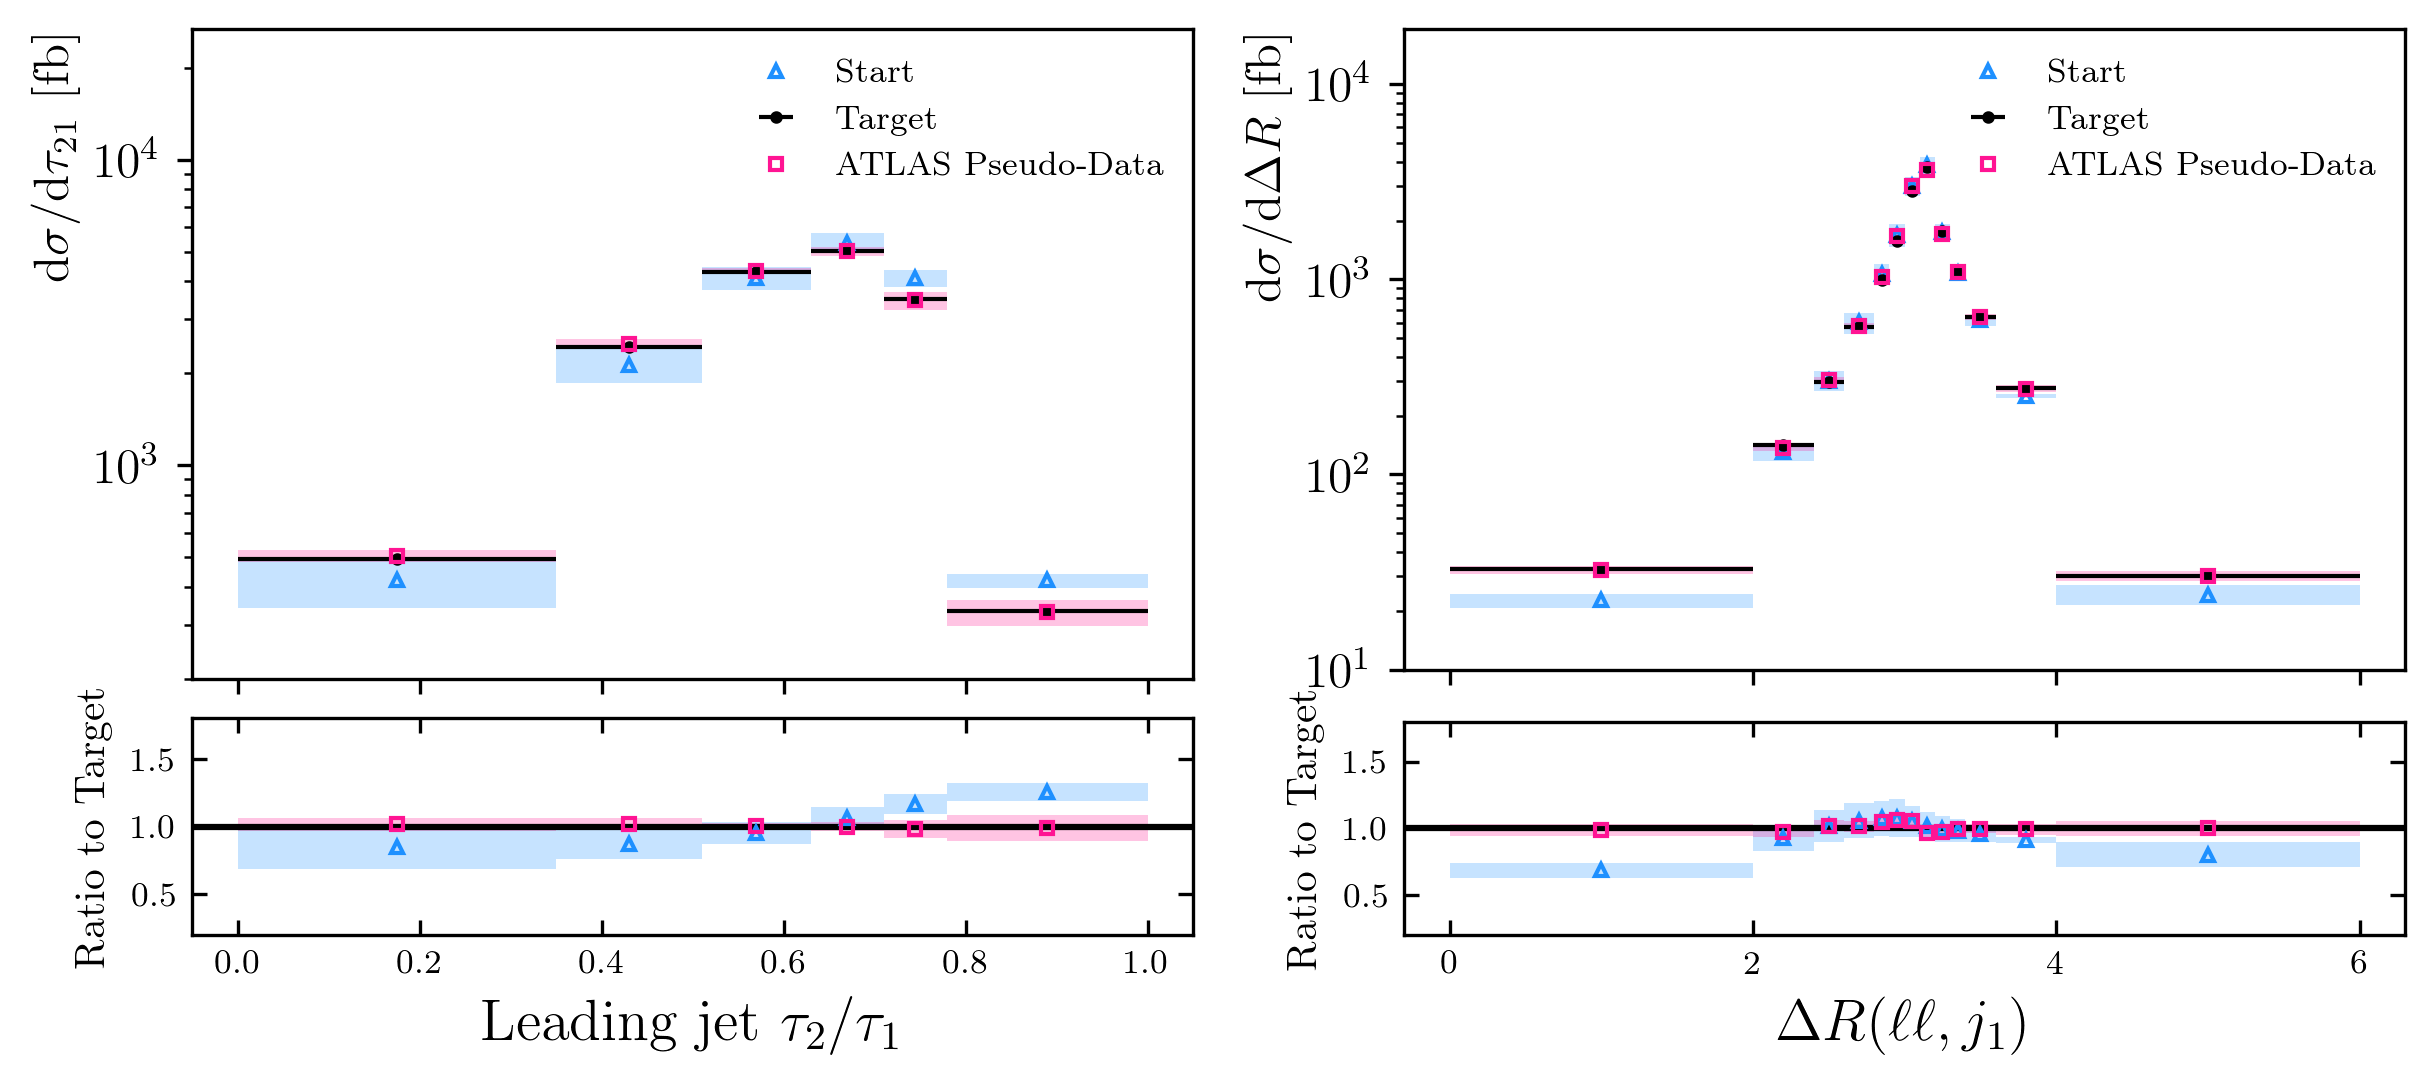

In [13]:
fig = plt.figure(figsize=(4*n_derived_vars,3.5), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(1, n_derived_vars)

for i, subfig in enumerate(tqdm(subfigs.flat, desc="Plots")):
    i = i+24 # skip to derived variables 
    axs = subfig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw = {'height_ratios':[3, 1]})
    
    var = list(bins_dict.items())[i][0]
    bins = np.array(list(bins_dict.items())[i][1])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = np.array([bins[n+1] - bins[n] for n in range(len(bins)-1)])
    
    if var == "tau21" or var == "dR_ll": 
        df = multifold[mask_trackj1]
    else:
        df = multifold 

    ### Starting distribution
    counts = mc_preds[i]['mgfxfx_counts']
    start_density = counts/lumi/bin_widths
    start_error = mc_preds[i]['mgfxfx_err']/mc_preds[i]['mgfxfx_counts']
    _ = make_error_boxes(axs[0], bin_centers, start_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([start_density*start_error, start_density*start_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label='Start')
    
    ### Target distribution (note: this is the pseudodata truth)
    target_density, _, _ = axs[0].hist(target[var], bins=bins, density=True, weights=target.weight_mc, color='k', alpha=0)
    target_density *= np.sum(target.weight_mc)
    axs[0].errorbar(bin_centers, target_density, xerr=bin_widths/2, yerr=None, marker=".", linestyle="None", color="k", alpha=1, ecolor='k', label="Target", markersize=4, linewidth=1)

    ### MultiFold
    multifold_density, _, _ = axs[0].hist(df[var], weights=df.weights_nominal, bins=bins, histtype= 'step', color= 'black', linewidth= 2, density=True, alpha=0)
    multifold_density *= np.sum(multifold.weights_nominal)
    _ = make_error_boxes(axs[0], bin_centers, multifold_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([multifold_density*uncertainties[var+"_total"]/100, multifold_density*uncertainties[var+"_total"]/100]), facecolor='deeppink', alpha=0.25, marker="s", label='ATLAS Pseudo-Data')

    axs[0].xaxis.set_tick_params(labelsize=12)
    axs[0].yaxis.set_tick_params(labelsize=12)
    axs[0].set_ylabel(labels[var], fontsize=12, loc='top')
    axs[0].legend(fontsize=8, frameon=False)
    axs[0].set_yscale('log')

    if var == 'tau21':
        axs[0].set_ylim([200, 5*max(max(start_density), max(multifold_density))])
    elif var == 'dR_ll':
        axs[0].set_ylim([10, 5*max(max(start_density), max(multifold_density))])
        
    ratio_truth = np.divide(multifold_density, target_density, where=(target_density != 0))
    axs[1].axhline(y=1, color='k')
    axs[1].xaxis.set_tick_params(labelsize=8, which='both', direction='in', top=True)
    axs[1].yaxis.set_tick_params(labelsize=8, which='both', direction='in', right=True)
    _ = make_error_boxes(axs[1], bin_centers, start_density/target_density,     np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(start_density/target_density)*start_error, (start_density/target_density)*start_error]), facecolor='dodgerblue', alpha=0.25, marker="^", label='Start')
    _ = make_error_boxes(axs[1], bin_centers, multifold_density/target_density, np.vstack([bin_widths/2,bin_widths/2]), np.vstack([(multifold_density/target_density)*uncertainties[var+"_total"]/100, (multifold_density/target_density)*uncertainties[var+"_total"]/100]), facecolor='deeppink', alpha=0.25, marker="s", label='ATLAS Pseudo-Data')
    axs[1].set_ylim([0.2,1.8])
    axs[1].set_ylabel('Ratio to Target', fontsize=10, labelpad=5)
    axs[1].set_xlabel(plot_labels[var], fontsize=14);
plt.savefig(os.path.join(plot_dir,"derived_diff_xsec.pdf"))

# Calculate $\chi^2$

In [14]:
for var_i in range(24): 
    var = list(bins_dict.items())[var_i][0]
    bins = np.array(list(bins_dict.items())[var_i][1])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = [bins[n+1] - bins[n] for n in range(len(bins)-1)]

    if "trackj1" in var: 
        df = multifold[mask_trackj1]
        df_sherpa = multifold_sherpa[mask_sherpa_trackj1]
        df_nonDY = multifold_nonDY[mask_nonDY_trackj1]
        df_target = target[mask_target_trackj1]
    elif "trackj2" in var:
        df = multifold[mask_trackj2]
        df_sherpa = multifold_sherpa[mask_sherpa_trackj2]
        df_nonDY = multifold_nonDY[mask_nonDY_trackj2]
        df_target = target[mask_target_trackj2]
    else:
        df = multifold
        df_sherpa = multifold_sherpa
        df_nonDY = multifold_nonDY
        df_target = target             
    
    ### Target distribution
    target_counts, _ = np.histogram(df_target[var], bins=bins, weights=df_target.weight_mc)    

    ### MultiFold
    nom, _         = np.histogram(df[var], bins=bins, weights=df.weights_nominal)    
    mc_stat_cov, _ = np.histogram(df[var], bins=bins, weights=df.weights_nominal**2)

    ### MC Stat
    mc_stat_bs = []
    for syst_name in mc_stat_systs:
        syst, _ = np.histogram(df[var], bins=bins, weights=df[syst_name])
        mc_stat_bs.append(syst)
    mc_bs = np.mean(mc_stat_bs, axis=0)

    ### Data Stat
    data_stat_bs = []
    for syst_name in data_stat_systs:
        syst, _ = np.histogram(df[var], bins=bins, weights=df[syst_name])
        data_stat_bs.append(syst)

    ### NN Initialization
    ensembles = []
    for syst_name in ensemble_systs:
        syst, _ = np.histogram(df[var], bins=bins, weights=df[syst_name])
        ensembles.append(syst)
    nn_init = np.mean(ensembles, axis=0)

    theory_bin_uncerts = []
    unfolding_dd_bin_uncerts = []
    unfolding_hv_bin_uncerts = []
    bkg_bin_uncerts = []

    ### Theory 
    for syst_name in theory_systs:
        syst, _ = np.histogram(df[var], bins=bins,  weights=df[syst_name])
        theory_bin_uncerts.append(syst - nom)
    
    ### Unfolding (DD)
    counts_dd, _ = np.histogram(df[var], bins=bins, weights=df.weights_dd)
    target_dd, _ = np.histogram(df[var], bins=bins, weights=df.target_dd)
    unfolding_dd_bin_uncerts.append((counts_dd - target_dd)*(nom/target_dd))
    
    ### Unfolding (HV)
    sherpa_counts, _ = np.histogram(df_sherpa[var], bins=bins, weights=df_sherpa.weights_nominal)
    unfolding_hv_bin_uncerts.append(smooth_uncertainty(sherpa_counts - nom, bin_centers))

    ### Top Background 
    syst, _ = np.histogram(df[var], bins=bins, weights=df.weights_topBackground)
    bkg_bin_uncerts.append(syst - nom)

    ### Non-Strong Background
    syst, _ = np.histogram(df_nonDY[var], bins=bins, weights=df_nonDY.weights_nominal)
    bkg_bin_uncerts.append(syst - nom)    

    ### CALCULATE COVARIANCE MATRIX
    n = len(bin_widths)
    n_bootstraps = 25

    ### MC stat covariance per bin
    v_mc = np.zeros((n, n), float)
    np.fill_diagonal(v_mc, mc_stat_cov) # only nonzero on the diagonal

    ### MC & Data Bootstrap uncertainty 
    v_bs_mc = fill_cov_matrix(n, mc_stat_bs, np.mean(mc_stat_bs, axis=0))
    v_bs_data = fill_cov_matrix(n, data_stat_bs, np.mean(data_stat_bs, axis=0))

    ### NN initialization uncertainty 
    v_nn = fill_cov_matrix(n, ensembles, np.mean(ensembles, axis=0))/100

    ### Other uncertainties
    v_theory = fill_cov_matrix(n, theory_bin_uncerts)
    v_bkg = fill_cov_matrix(n, bkg_bin_uncerts)
    v_unfolding_dd = fill_cov_matrix(n, unfolding_dd_bin_uncerts)
    v_unfolding_hv = fill_cov_matrix(n, unfolding_hv_bin_uncerts)

    ### Construct covariance matrix
    v_total = v_mc + v_bs_mc + v_bs_data + v_nn + v_theory + v_unfolding_dd + v_unfolding_hv + v_bkg

    ### Calculate chi squared 
    from scipy import stats 
    dof = len(bins)-1
    D = nom - target_counts
    chi_2 = D.dot(np.linalg.inv(v_total)).dot(D.T) 
    p_value = 1 - stats.chi2.cdf(chi_2, dof)
    
    if p_value < 0.01: 
        print(f"WARNING: Initial p-value of {p_value} for {var} is too small -- using decorrelated covariance matrix instead.")
        ### decorrelate HV, i.e. set all off-diag elements to 0:
        v_unfolding_hv_decorr = np.diag(np.diag(v_unfolding_hv))
        v_unfolding_dd_decorr = np.diag(np.diag(v_unfolding_dd))
        v_total_decorr = v_mc + v_bs_mc + v_bs_data + v_nn + v_theory + v_unfolding_dd_decorr + v_unfolding_hv_decorr + v_bkg
        chi_2 = D.dot(np.linalg.inv(v_total_decorr)).dot(D.T) 
        p_value = 1 - stats.chi2.cdf(chi_2, dof)
    
    print(f"{var:<20} dof: {dof:<7} χ2: {chi_2:.5f} \t p value: {p_value:.4f}")

pT_l1                dof: 6       χ2: 11.01103 	 p value: 0.0880
pT_l2                dof: 6       χ2: 10.68616 	 p value: 0.0986
eta_l1               dof: 14      χ2: 18.19845 	 p value: 0.1979
eta_l2               dof: 14      χ2: 12.03006 	 p value: 0.6039
phi_l1               dof: 16      χ2: 19.79036 	 p value: 0.2298
phi_l2               dof: 16      χ2: 13.41401 	 p value: 0.6423
pT_trackj1           dof: 6       χ2: 13.37187 	 p value: 0.0375
pT_trackj2           dof: 4       χ2: 1.73601 	 p value: 0.7842
y_trackj1            dof: 18      χ2: 10.40634 	 p value: 0.9178
y_trackj2            dof: 10      χ2: 3.60559 	 p value: 0.9634
phi_trackj1          dof: 16      χ2: 4.05499 	 p value: 0.9988
phi_trackj2          dof: 16      χ2: 6.52962 	 p value: 0.9813
pT_ll                dof: 5       χ2: 4.97659 	 p value: 0.4187
y_ll                 dof: 14      χ2: 19.70013 	 p value: 0.1399
Ntracks_trackj1      dof: 6       χ2: 6.83001 	 p value: 0.3369
Ntracks_trackj2      dof: 5    